# Rozpoznawanie Komórek Krwi na Zdjęciach przy Pomocy AI

## 🎯 Cel Projektu

Celem projektu jest stworzenie modelu opartego na sztucznej inteligencji, zdolnego do rozpoznawania i klasyfikacji różnych typów komórek krwi na podstawie obrazów mikroskopowych. Model ten może wspierać diagnostykę medyczną, pomagając w wykrywaniu chorób krwi poprzez automatyczną klasyfikację komórek.

## 🔬 Tło i Motywacja

Analiza komórek krwi jest kluczowym elementem diagnostyki wielu schorzeń, takich jak białaczka czy anemia. Obecnie klasyfikacja komórek dalej często odbywa się ręcznie przez specjalistów, co może być czasochłonne i podatne na błędy ludzkie. Automatyzacja tego procesu przy pomocy głębokiego uczenia może poprawić precyzję diagnozy oraz usprawnić pracę lekarzy.

## 🏗 Opis Rozwiązania

Projekt koncentruje się na stworzeniu oraz wytrenowaniu konwolucyjnej sieci neuronowej (CNN) do klasyfikacji obrazów komórek krwi. Dwa modele o różnej złożoności zostaną porównane pod względem skuteczności i czasu trenowania.

## 🛠 Technologie i Narzędzia

- **Język programowania**: Python
- **Biblioteki**: TensorFlow, Keras, NumPy, OpenCV, Matplotlib
- **Środowisko**: Jupyter Notebook / Google Colab

## 📊 Zbór Danych

Zbór danych pochodzi z: [Blood Cell Images](https://www.kaggle.com/datasets/paultimothymooney/blood-cells) i zawiera obrazy mikroskopowe komórek krwi w formacie RGB (320x240 px)

4 klasy komórek:

- **EOSINOPHIL**
- **LYMPHOCYTE**
- **MONOCYTE**
- **NEUTROPHIL**

### Import modułów

In [3]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers

print(tf.__version__)

2.16.1


### Wczytywanie zbioru danych

Found 9957 files belonging to 4 classes.
Found 2487 files belonging to 4 classes.


2025-02-26 10:55:43.845337: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


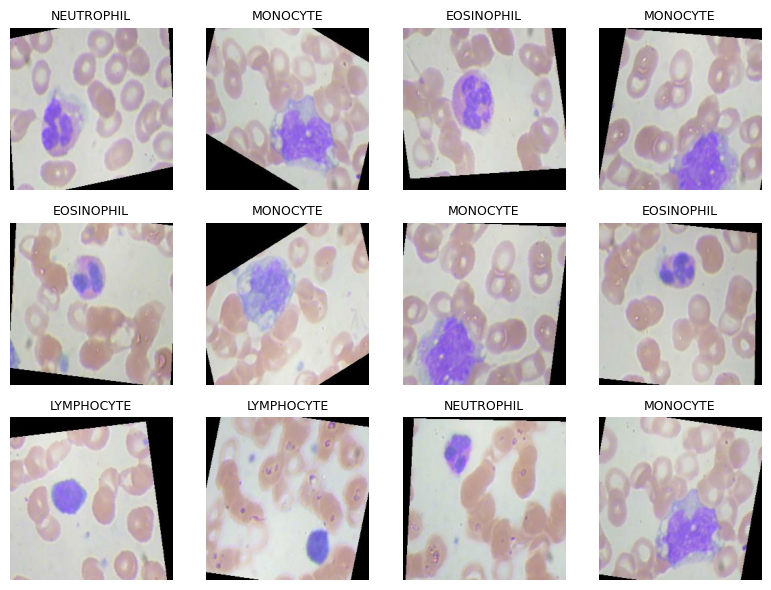

In [4]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

# Parametry
IMG_SIZE = (320, 240)
TARGET_SIZE = (240, 240)
BATCH_SIZE = 32
TRAIN_DIR = "images/TRAIN"
TEST_DIR = "images/TEST"

# Wczytanie zbioru treningowego
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    TRAIN_DIR,
    image_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    color_mode='rgb',
    label_mode='categorical'  # Bo mamy więcej niż 2 klasy
)

# Wczytanie zbioru testowego
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    TEST_DIR,
    image_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    color_mode='rgb',
    label_mode='categorical'  # Bo mamy więcej niż 2 klasy
)

# Pobranie nazw klas
class_names = train_dataset.class_names

# Normalizacja wartości pikseli
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
test_dataset = test_dataset.map(lambda x, y: (normalization_layer(x), y))

# Podgląd danych z nazwami klas
plt.figure(figsize=(8, 6))
for images, labels in train_dataset.take(1):
    for i in range(12):
        plt.subplot(3, 4, i + 1)
        plt.imshow(images[i].numpy())
        plt.axis("off")

        # Pobranie indeksu klasy i wyświetlenie nazwy
        class_index = np.argmax(labels[i].numpy())
        plt.title(class_names[class_index], fontsize=9)

plt.tight_layout()
plt.show()



## 🏗 Budowa Modelu

1. Warstwy wejściowej przetwarzającej obrazy (240x240 px, RGB)
2. Trzech bloków konwolucyjnych z filtrami i warstwami poolingowymi
3. Warstwy spłaszczająca (Flatten)
4. Gęstej warstwy w pełni połączonej (Dense)
5. Warstwy wyjściowej (4 klasy, softmax)


In [45]:
model = tf.keras.Sequential([
    layers.InputLayer((240, 240, 3)),
    layers.Conv2D(32, (3,3), activation='relu', padding="same"),
    layers.BatchNormalization(),
    layers.MaxPooling2D(4,4),
    layers.Conv2D(32, (3,3), activation='relu', padding="same"),
    layers.BatchNormalization(),
    layers.MaxPooling2D(3,3),
    layers.Conv2D(16, (3,3), activation='relu', padding="same"),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2,2),
    layers.BatchNormalization(),

    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(4, activation='softmax')
])


model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_93 (Conv2D)              │ (None, 240, 240, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_87          │ (None, 240, 240, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_77 (MaxPooling2D) │ (None, 60, 60, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_94 (Conv2D)              │ (None, 60, 60, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_88          │ (None, 60, 60, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_78 (MaxPooling2D) │ (None, 20, 20, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_95 (Conv2D)              │ (None, 20, 20, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_89          │ (None, 20, 20, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_79 (MaxPooling2D) │ (None, 10, 10, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_90          │ (None, 10, 10, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_23 (Flatten)            │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_64 (Dense)                │ (None, 64)             │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_65 (Dense)                │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 117,876 (460.45 KB)

 Trainable params: 117,684 (459.70 KB)

 Non-trainable params: 192 (768.00 B)

## 🔧 Trenowanie Modelu

Modele trenowane są przez 10 epok na zestawie treningowym, a do ewaluacji wykorzystywane są metryki dokładności (accuracy) oraz funkcja straty (loss). Dopasowywanie pierwszego modelu zajmuje ok 16.5. Wykorzystywany sprzęt: **Intel® Core™ Ultra 7 Processor 165H - laptop**

In [46]:
EPOCHS = 10

history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=EPOCHS,
    steps_per_epoch=len(train_dataset)
)

# Zapisanie modelu
model.save("blood_cell_classifier_small.h5")

Epoch 1/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 86s 269ms/step - accuracy: 0.3288 - loss: 1.4061 - val_accuracy: 0.3450 - val_loss: 2.0686
Epoch 2/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 86s 275ms/step - accuracy: 0.7779 - loss: 0.5400 - val_accuracy: 0.3876 - val_loss: 2.6805
Epoch 3/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 90s 289ms/step - accuracy: 0.9141 - loss: 0.2282 - val_accuracy: 0.4584 - val_loss: 3.0518
Epoch 4/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 100s 319ms/step - accuracy: 0.9462 - loss: 0.1400 - val_accuracy: 0.3534 - val_loss: 5.8015
Epoch 5/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 106s 340ms/step - accuracy: 0.9703 - loss: 0.0851 - val_accuracy: 0.6683 - val_loss: 1.3111
Epoch 6/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 106s 339ms/step - accuracy: 0.9780 - loss: 0.0651 - val_accuracy: 0.3647 - val_loss: 6.4876
Epoch 7/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 106s 338ms/step - accuracy: 0.9894 - loss: 0.0341 - val_accuracy: 0.3715 - val_loss: 22.7285
Epoch 8/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 104s 334ms/step - accuracy: 0.9833 - l

## 🏗 Budowanie mniejszego modelu

1. Warstwa wejściowa przetwarzająca obrazy (240x240 px, RGB)
2. Dwa bloki warstw konwolucyjnych z filtrami i warstwami poolingowymi
3. Warstwa spłaszczającej (Flatten)
4. Gęsta warstwa w pełni połączona (Dense)
5. Warstwa odrzucająca połowę wyników (Dropout)
6. Warstwa wyjściowa (4 klasy, softmax)

In [51]:
model2 = tf.keras.Sequential([
    layers.InputLayer((240, 240, 3)),
    layers.Conv2D(16, (3,3), activation='relu', padding="same"),
    layers.BatchNormalization(),
    layers.MaxPooling2D(4,4),
    layers.Conv2D(16, (3,3), activation='relu', padding="same"),
    layers.BatchNormalization(),
    layers.MaxPooling2D(4,4),

    layers.Flatten(),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(4, activation='softmax')
])


model2.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model2.summary()


Model: "sequential_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_102 (Conv2D)             │ (None, 240, 240, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_97          │ (None, 240, 240, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_86 (MaxPooling2D) │ (None, 60, 60, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_103 (Conv2D)             │ (None, 60, 60, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_98          │ (None, 60, 60, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_87 (MaxPooling2D) │ (None, 15, 15, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_27 (Flatten)            │ (None, 3600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_72 (Dense)                │ (None, 32)             │       115,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_42 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_73 (Dense)                │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 118,260 (461.95 KB)

 Trainable params: 118,196 (461.70 KB)

 Non-trainable params: 64 (256.00 B)

## Dopasowywanie mniejszego modelu

Dopasowanie mniejszego modelu zajęło ok 8 min.

In [52]:
EPOCHS = 10

history2 = model2.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=EPOCHS,
    steps_per_epoch=len(train_dataset)
)

# Zapisanie modelu
model2.save("blood_cell_classifier_even_smaller.h5")


Epoch 1/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 44s 136ms/step - accuracy: 0.2531 - loss: 1.5249 - val_accuracy: 0.2533 - val_loss: 1.3860
Epoch 2/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 45s 145ms/step - accuracy: 0.2422 - loss: 1.3864 - val_accuracy: 0.2493 - val_loss: 1.3863
Epoch 3/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 48s 154ms/step - accuracy: 0.2435 - loss: 1.3864 - val_accuracy: 0.2509 - val_loss: 1.3863
Epoch 4/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 50s 161ms/step - accuracy: 0.2554 - loss: 1.3863 - val_accuracy: 0.2493 - val_loss: 1.3863
Epoch 5/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 51s 163ms/step - accuracy: 0.2448 - loss: 1.3864 - val_accuracy: 0.2493 - val_loss: 1.3863
Epoch 6/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 51s 164ms/step - accuracy: 0.2386 - loss: 1.3864 - val_accuracy: 0.2493 - val_loss: 1.3863
Epoch 7/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 52s 166ms/step - accuracy: 0.2404 - loss: 1.3864 - val_accuracy: 0.2493 - val_loss: 1.3863
Epoch 8/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 49s 157ms/step - accuracy: 0.2440 - loss: 1

## 📉 Porównanie Modeli

- **Model 1 (większy):**
  - Dokładność: **58.5%**
  - Strata: **4.23**
- **Model 2 (mniejszy, szybszy):**
  - Dokładność: **24.9%**
  - Strata: **1.39**

In [57]:
# Ewaluacja modeli
loss1, acc1 = model.evaluate(test_dataset, verbose=0)
print(f"Model 1 - strata: {loss1:.4f}, dokładność: {acc1:.4f}")

loss2, acc2 = model2.evaluate(test_dataset, verbose=0)
print(f"Model 2 - strata: {loss2:.4f}, dokładność: {acc2:.4f}")


Model 1 - strata: 4.2308, dokładność: 0.5850
Model 2 - strata: 1.3863, dokładność: 0.2493


## Wnioski

Model 1 (większy) osiągnął dokładność 58.5%, ale jego strata jest wysoka (4.23). Oznacza to, że model może mieć problem z dobrze dopasowanymi predykcjami, ale mimo to klasyfikuje lepiej niż losowo.

Model 2 (mniejszy) ma niższą stratę (1.39), ale jego dokładność jest niska (24.9%). Oznacza to, że model jest zbyt prosty i nie nauczył się wystarczająco dobrze.

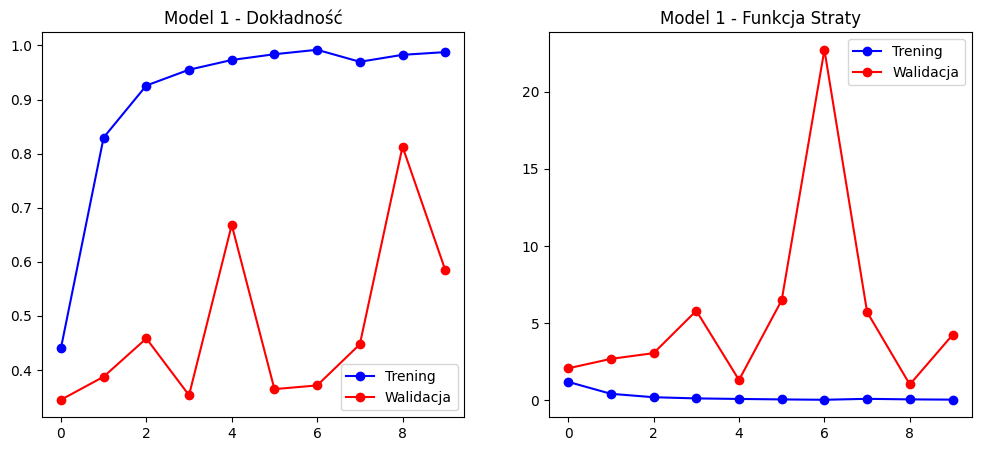

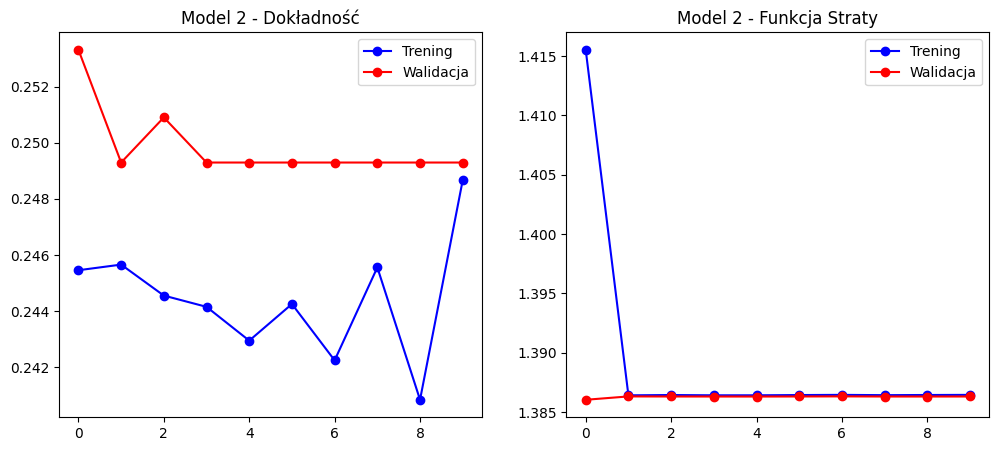

In [58]:
def plot_history(history, title):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.figure(figsize=(12,5))

    # Wykres dokładności
    plt.subplot(1,2,1)
    plt.plot(epochs, acc, 'bo-', label='Trening')
    plt.plot(epochs, val_acc, 'ro-', label='Walidacja')
    plt.title(f'{title} - Dokładność')
    plt.legend()

    # Wykres funkcji straty
    plt.subplot(1,2,2)
    plt.plot(epochs, loss, 'bo-', label='Trening')
    plt.plot(epochs, val_loss, 'ro-', label='Walidacja')
    plt.title(f'{title} - Funkcja Straty')
    plt.legend()

    plt.show()

# Rysowanie wykresów
plot_history(history, "Model 1")
plot_history(history2, "Model 2")

## 📈 Możliwe Ulepszenia

Dalsze prace nad modelem mogłyby obejmować dodanie kolejnych warstw sieci neuronowej, zwiększenie zbioru danych treningowych oraz zastosowanie augmentacji obrazów poprzez zmiany nasycenia czy jasności. Użycie technik transfer learningu, takich jak pretrenowane modele ResNet, mogłoby również znaczną poprawić wyniki klasyfikacji. Aby uniknąć przetrenowania, warto byłoby także wdrożyć mechanizmy regularyzacji, takie jak dropout czy L2.

## 📌 Podsumowanie

Projekt pokazuje możliwości wykorzystania AI w diagnostyce medycznej, jednak osiągnięte wyniki wskazują na konieczność dalszych optymalizacji. Lepsze modele osiągają nawet **98.5%** dokładności ([przykład](https://www.kaggle.com/code/mohamedgobara/blood-cell-images-using-cnn-model-98-5)), co sugeruje, że dalsza praca nad architekturą modelu może przynieść znacznie lepsze rezultaty.

## 🚀 Dalszy Rozwój Projektu

W przyszłości możliwa jest integracja modelu z aplikacją webową umożliwiającą diagnostykę online oraz testowanie modelu na nowych zbiorach danych. Ponadto implementacja sieci Transformer mogłaby poprawić jakość klasyfikacji komórek krwi.

---

📝 Autor: *Patryk Wawrzyniak*  
📅 Data: *2025-02-26*
